# Hakai Profile QA/QC Development Tool
This jupyter notebook is a flexible tool used for testing and improving Hakai's QA/QCing workflow of the its CTD profile data. 

The tool can load Hakai's CTD dataset and apply default tests already applied. Those tests can be modified by the user to tests different thresholds. Other tests can be added too!

## Let's load all the python packages we need
This may take some times the very first time. Some of the packages are available through Pypi while others aren't. We also load the hakai_qc main branch here.

We also install the ioos_qc tool from the Hakai github fork and add-density-inversion-test branch. This will likely change in th future as some new tests gets integrated int he standard ioos_qc package.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

# Get External packages
try:
    from hakai_api import Client
    from ioos_qc.config import QcConfig
    import hakai_qc
except:
    # Install Hakai API Python Client
    !pip install git+https://github.com/HakaiInstitute/hakai-api-client-python.git
    from hakai_api import Client

    # Install ioos_qc
    !pip install git+https://github.com/HakaiInstitute/ioos_qc@add-density-inversion-test
    from ioos_qc.config import QcConfig
    
    # Load local modules
    !pip install git+https://github.com/HakaiInstitute/hakai-profile-qaqc.git
    import hakai_qc


## Import data from the Hakai CTD Profile Database and Hakai List of Stations
The Hakai Station Master List is based on a CSV output of the [Hakai Oceanography Master Stations Map and Data](https://hakai.maps.arcgis.com/apps/webappviewer/index.html?id=38e1b1da8d16466bbe5d7c7a713d2678). Missing sites should be added to the master list in order to applied all the different tests.

In [2]:
# Load Hakai Station List
hakai_stations = hakai_qc.get.hakai_stations()

Now, let's get some data from the Hakai CTD Processed Data Database 

In [3]:
# Get Hakai CTD Data Download through the API
variable_lists = hakai_qc.get.hakai_api_selected_variables()

# Let's just get the data from QU39
filterUrl = 'station=QU39&status!=MISCAST&limit=-1'+'&fields='+','.join(variable_lists)
#filterUrl = 'station=QU39&status!=MISCAST&limit=-1'+fields
df, url = hakai_qc.get.hakai_ctd_data(filterUrl)
print(str(len(df))+' records found')

# Regroup profiles and sort them by pressure
group_variables = ['device_model','device_sn','ctd_file_pk','ctd_cast_pk','direction_flag']
df = df.sort_values(by=group_variables+['pressure'])

# Get Derived Variables
df = hakai_qc.utils.derived_ocean_variables(df)

# Just show the first few lines to have a look
df.head() # Show the top of the data frame

Please go here and authorize:
https://hecate.hakai.org/api/auth/oauth2?response_type=code&client_id=289782143400-1f4r7l823cqg8fthd31ch4ug0thpejme.apps.googleusercontent.com&state=DdyI2DgQvSBvGCimV2jfK4uFQeWxYM



Paste the full redirect URL here:
 https://hecate.hakai.org/api/auth/oauth2/callback?state=DdyI2DgQvSBvGCimV2jfK4uFQeWxYM&code=4/0AY0e-g5RwJiJw1CwWg9GjYcZ4qSDk2fyRNnQUczpwj5x-IMa0FQavQWEY5wimyBliFI7Sg&scope=email%20profile%20https://www.googleapis.com/auth/userinfo.profile%20https://www.googleapis.com/auth/userinfo.email%20openid&authuser=0&hd=hakai.org&prompt=none


133924 records found


C:\Users\jessy\Anaconda3\lib\site-packages\gsw\_wrapped_ufuncs.py:696: RuntimeWarning: invalid value encountered in ct_from_t
  return _gsw_ufuncs.ct_from_t(SA, t, p)


,ctd_file_pk,ctd_cast_pk,hakai_id,ctd_data_pk,filename,device_model,device_sn,work_area,cruise,station,...,sos_un,sos_un_flag,backscatter_beta,backscatter_beta_flag,cdom_ppb,cdom_ppb_flag,absolute salinity,conservative temperature,density,sigma0
117244,2745,7913,080217_2017-01-05T17:32:36.333Z,9169911,080217_20170105_1317,RBRconcerto,080217,QUADRA,QOMB,QU39,...,None,None,None,None,None,None,28.019280,6.838949,1021.857610,21.852974
117245,2745,7913,080217_2017-01-05T17:32:36.333Z,9169912,080217_20170105_1317,RBRconcerto,080217,QUADRA,QOMB,QU39,...,None,None,None,None,None,None,28.009184,6.862007,1021.851638,21.842369
117246,2745,7913,080217_2017-01-05T17:32:36.333Z,9169913,080217_20170105_1317,RBRconcerto,080217,QUADRA,QOMB,QU39,...,None,None,None,None,None,None,28.008935,6.854664,1021.856944,21.843039
117247,2745,7913,080217_2017-01-05T17:32:36.333Z,9169914,080217_20170105_1317,RBRconcerto,080217,QUADRA,QOMB,QU39,...,None,None,None,None,None,None,28.009692,6.854777,1021.862157,21.843617
117248,2745,7913,080217_2017-01-05T17:32:36.333Z,9169915,080217_20170105_1317,RBRconcerto,080217,QUADRA,QOMB,QU39,...,None,None,None,None,None,None,28.013262,6.863834,1021.868514,21.845340


## Test Configuration
We first import the different tests that applied as of now to the Hakai Dataset. You can also add new tests by adding a related dictionary which follow the structure presented below. For more information on the different tests available, have a look at the [ioos_qc webpage](https://ioos.github.io/ioos_qc/api/ioos_qc.html).

In [5]:
# Load default test parameters used right now!
qc_config = hakai_qc.get.json_config('hakai_ctd_profile.json')

# If you want to add or modify some of the tests do it here
#ex: let's add for the range of fluorescence 
qc_config['flc']= {'qartod': {
                        'gross_range_test': {   
                            "suspect_span": [0, 70],
                            "fail_span": [-.5, 100],
                        },
    
                        "aggregate": {}    
                        }
                   }
# Show the QC config in a nice looking table
hakai_qc.get.config_as_dataframe(qc_config)

Value
Variable              Module Test                   Input                                              
position              qartod location_test          bbox                           [-180, -90, 180, 90]
                                                    range                                          3000
pressure              qartod gross_range_test       suspect_span                             [0, 12000]
                                                    fail_span                                [0, 12000]
                                                    maximum_suspect_depth_ratio                    1.05
                                                    maximum_fail_depth_ratio                        1.1
depth                 qartod gross_range_test       suspect_span                             [0, 12000]
                                                    fail_span                                [0, 12000]
                                                    maximum_suspect_depth_ratio                    1.05
                                                    maximum_fail_depth_ratio                        1.1
dissolved_oxygen_ml_l qartod gross_range_test       fail_span                                   [0, 12]
                                                    suspect_span                                [1, 10]
                             rate_of_change_test    threshold                                         1
                             spike_test             suspect_threshold                               0.5
                                                    fail_threshold                                    1
                             attenuated_signal_test suspect_threshold                               0.5
                                                    fail_threshold                                  0.2
                                                    check_type                                    range
rinko_do_ml_l         qartod gross_range_test       fail_span                                   [0, 12]
                                                    suspect_span                                [1, 10]
                             rate_of_change_test    threshold                                         1
                             spike_test             suspect_threshold                               0.5
                                                    fail_threshold                                    1
                             attenuated_signal_test suspect_threshold                               0.5
                                                    fail_threshold                                  0.2
                                                    check_type                                    range
turbidity             qartod gross_range_test       fail_span                             [-0.1, 10000]
                                                    suspect_span                              [0, 1000]
                             attenuated_signal_test suspect_threshold                              0.01
                                                    fail_threshold                                0.001
                                                    check_type                                    range
c_star_at             qartod attenuated_signal_test suspect_threshold                             0.002
                                                    fail_threshold                               0.0001
                                                    check_type                                    range
                             spike_test             suspect_threshold                              0.05
                                                    fail_threshold                                  0.5
par                   qartod gross_range_test       fail_span                            [-0.2, 100000]
                                          

## Run Test on Data
All the different tests listed above are applied to station and each profiles one at the time. 


In [6]:
# Run all the tests on each available profiles
df = hakai_qc.run.tests_on_profiles(df,hakai_stations,qc_config)

QAQC QU39
  position
    qartod
      ('location_test', {'bbox': [-125.14107014641213, 50.00372871260039, -125.05732985358786, 50.05767116137374], 'range': 3000})
      ('aggregate', {})
  pressure
    qartod
      ('gross_range_test', {'suspect_span': [0, 280.83826311944904], 'fail_span': [0, 294.2115137441847], 'maximum_suspect_depth_ratio': 1.05, 'maximum_fail_depth_ratio': 1.1})
      ('aggregate', {})
  depth
    qartod
      ('gross_range_test', {'suspect_span': [0, 278.25], 'fail_span': [0, 291.5], 'maximum_suspect_depth_ratio': 1.05, 'maximum_fail_depth_ratio': 1.1})
      ('aggregate', {})
  dissolved_oxygen_ml_l
    qartod
      ('gross_range_test', {'fail_span': [0, 12], 'suspect_span': [1, 10]})
      ('rate_of_change_test', {'threshold': 1})
      ('spike_test', {'suspect_threshold': 0.5, 'fail_threshold': 1})
      ('attenuated_signal_test', {'suspect_threshold': 0.5, 'fail_threshold': 0.2, 'check_type': 'range'})
      ('aggregate', {})
  rinko_do_ml_l
    qartod
      (

## Review Results
### Profile location versus target location (station)
We present here the result of the analysis of the lat/long position recorded for the drop and its distance from the target station. 


In [15]:
# Give me all the drops that had their position flagged
df[df['position_qartod_aggregate']>1].groupby('hakai_id').first()[['position_qartod_aggregate',
                                                                   'station','latitude',
                                                                   'longitude','measurement_dt']]

,position_qartod_aggregate,station,latitude,longitude,measurement_dt
hakai_id,,,,,
01907467_2015-06-30T14:36:15Z,9.0,QU39,50.030668,-125.099217,2015-06-30T14:36:15.000Z
01907467_2015-07-07T14:58:36Z,9.0,QU39,50.030668,-125.099217,2015-07-07T14:58:36.000Z
01907467_2015-07-28T15:42:47Z,9.0,QU39,50.030668,-125.099217,2015-07-28T15:42:47.000Z
01907467_2015-08-12T15:48:15Z,9.0,QU39,50.030668,-125.099217,2015-08-12T15:48:15.000Z
01907467_2015-09-02T16:10:27Z,9.0,QU39,50.030668,-125.099217,2015-09-02T16:10:27.000Z
01907674_2016-04-27T17:37:15Z,9.0,QU39,50.030668,-125.099217,2016-04-27T17:37:15.000Z
01907674_2017-07-17T16:02:34Z,9.0,QU39,NaN,NaN,2017-07-17T16:05:50.163Z
01907674_2017-08-08T15:09:00Z,9.0,QU39,NaN,NaN,2017-08-08T15:12:13.829Z
01907674_2017-08-08T16:34:48Z,9.0,QU39,NaN,NaN,2017-08-08T16:37:38.271Z


In [16]:
# Show me them on a map
m = hakai_qc.get.flag_result_map(df.dropna(axis=0,subset=['latitude','longitude']))
m

### Profile test flags
Let's filter all the data that actually got flagged and keep only the downcast.

In [22]:
# Get Variables to plot (first line gives a list of a the variables that are tested, the second overwrite the first if you want to look into one or few specific variables)
variables_to_plot = set(qc_config.keys())-{'position','depth','pressure','sigma0'}                    
variables_to_plot = ["temperature","salinity","dissolved_oxygen_ml_l","turbidity"]

# Review Flagged data (let's look at only the downcast)
flag_columns = [var+'_qartod_aggregate' for var in variables_to_plot]
flagged_hakai_id = df.where(df['direction_flag']=='d')[((df.filter(items=flag_columns)>1) 
                       & (df.filter(items=flag_columns)!=9)).any(axis=1)]['hakai_id'].dropna().unique()              

# Tell me how many there is
print(str(len(flagged_hakai_id))+' profiles were flagged')

101 profiles were flagged


Show me the results in a some figures!

080217_2017-01-05T17:32:36.333Z
080217_2016-12-03T17:31:39.667Z
080217_2016-12-03T18:18:34.500Z
080217_2016-12-03T18:48:03.000Z
080217_2017-01-14T17:15:40.333Z
080217_2017-01-26T16:56:39.000Z
080217_2017-01-26T17:09:57.500Z
080217_2017-01-26T17:46:24.000Z
080217_2017-01-24T19:02:00.833Z
080217_2016-12-15T17:32:37.500Z
080217_2016-12-15T17:43:16.667Z
080217_2016-12-15T19:12:50.000Z
080217_2017-02-25T18:26:51.000Z
080217_2016-11-28T20:28:39.167Z
080217_2017-02-02T20:05:06.000Z
080217_2017-01-15T17:57:21.667Z
080217_2017-01-15T18:06:32.000Z
080217_2017-01-15T18:53:56.833Z
080217_2016-11-26T17:24:19.333Z
080217_2016-11-26T20:23:06.500Z


<Figure size 432x288 with 0 Axes>

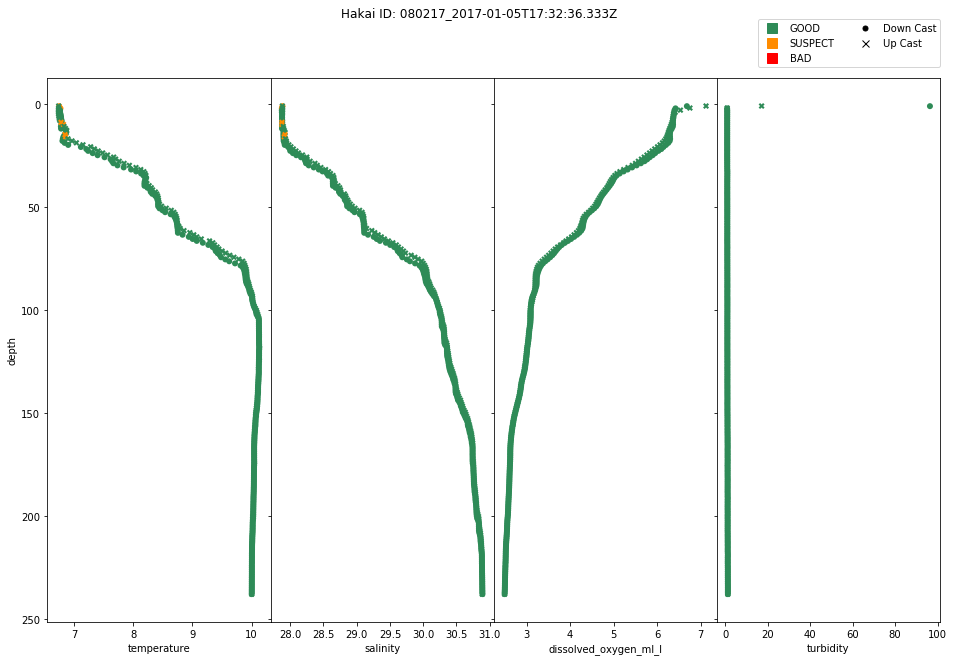

<Figure size 432x288 with 0 Axes>

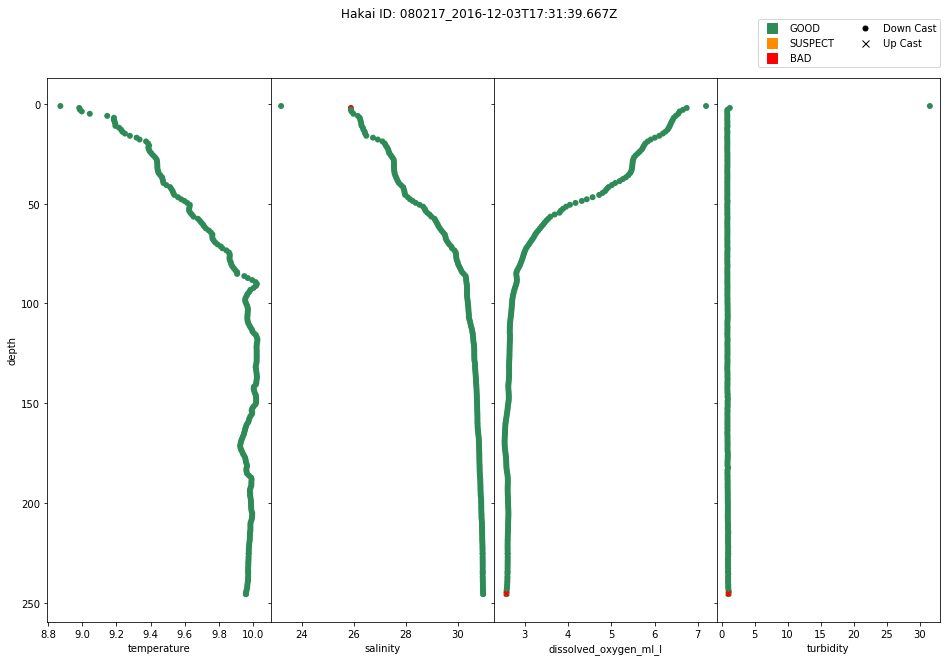

<Figure size 432x288 with 0 Axes>

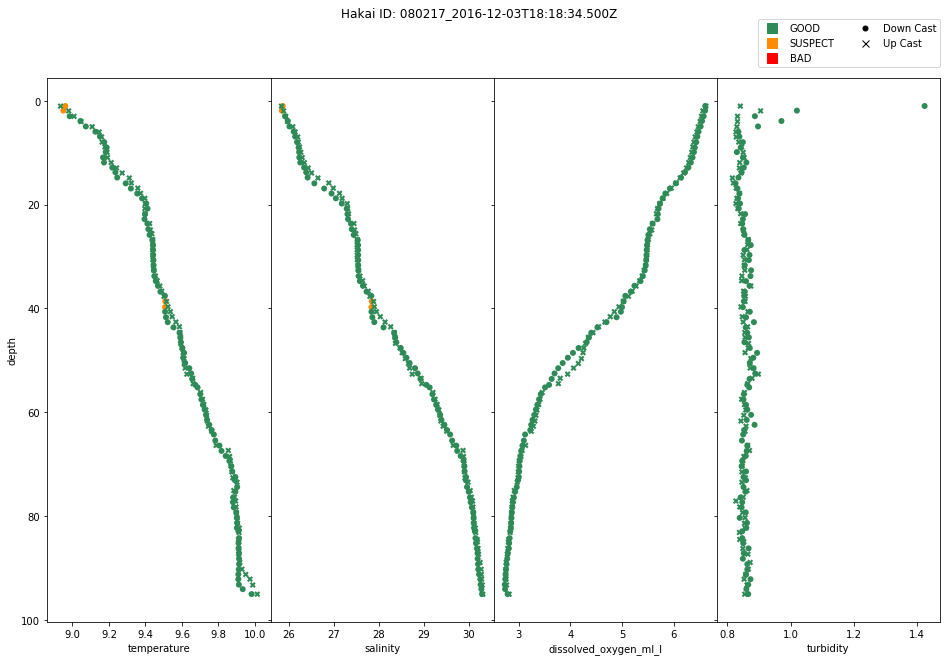

<Figure size 432x288 with 0 Axes>

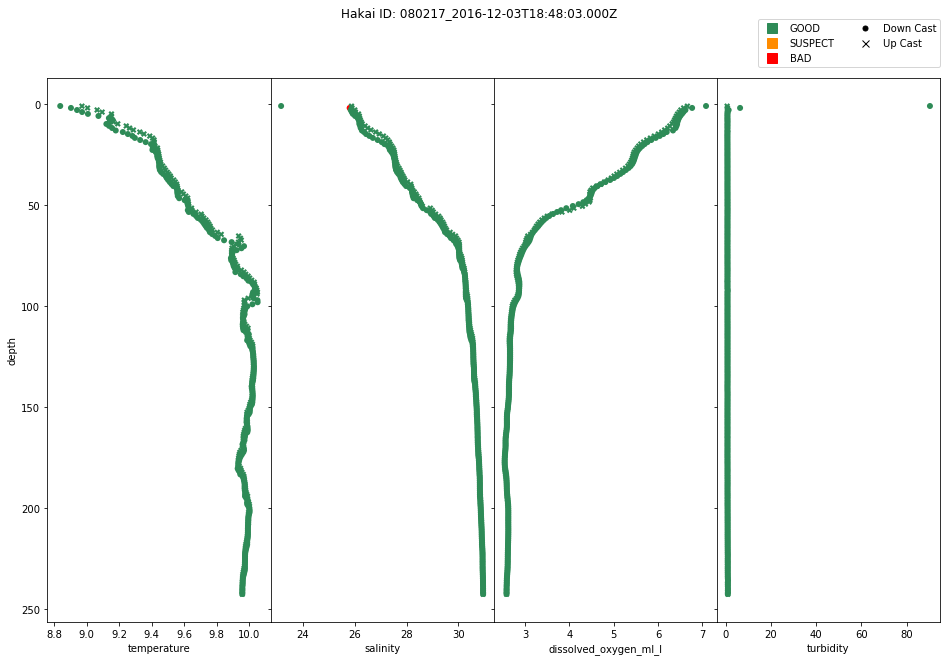

<Figure size 432x288 with 0 Axes>

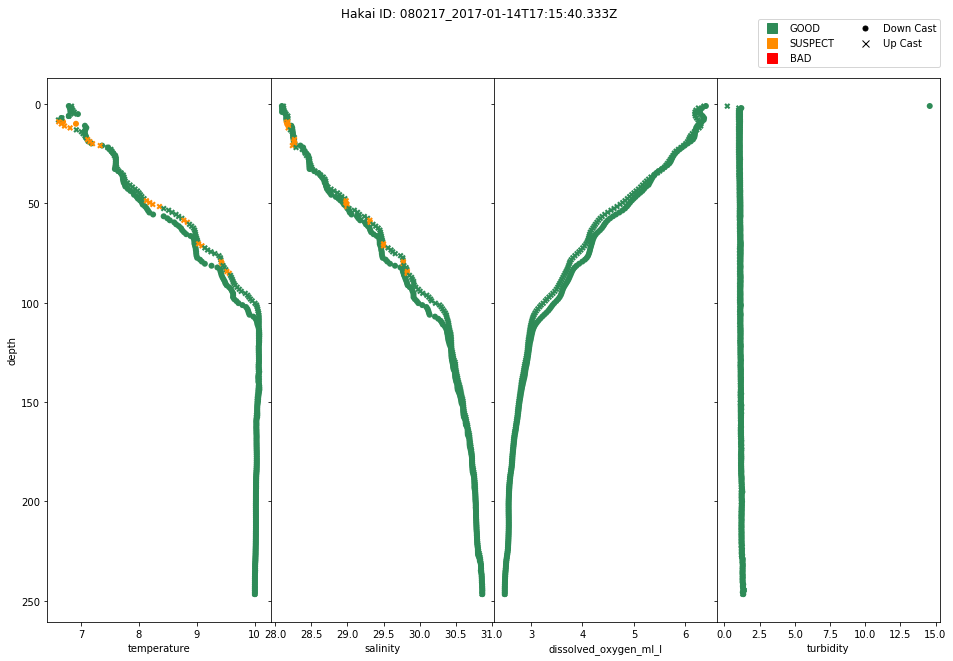

<Figure size 432x288 with 0 Axes>

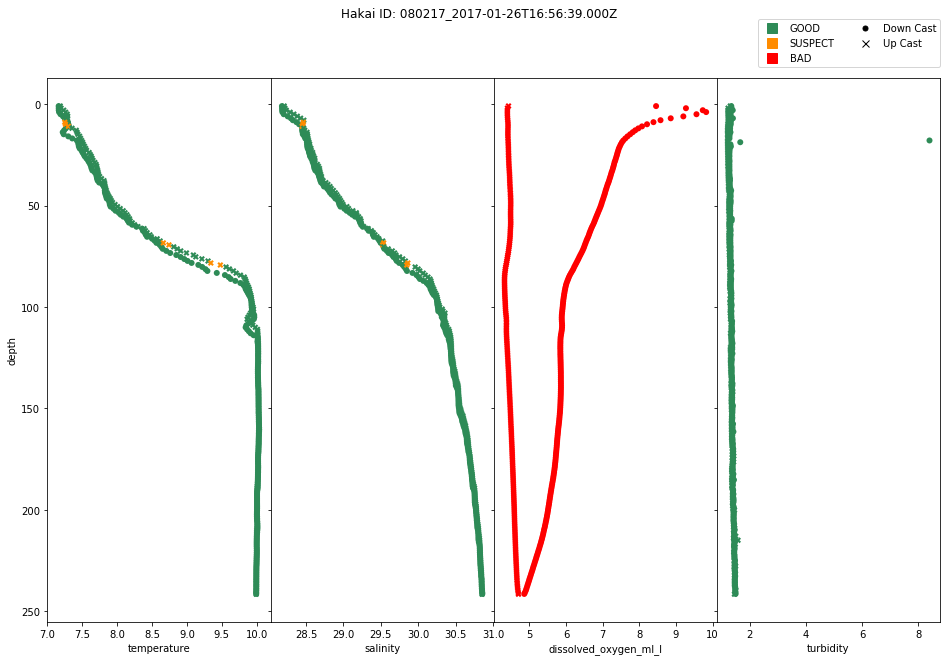

<Figure size 432x288 with 0 Axes>

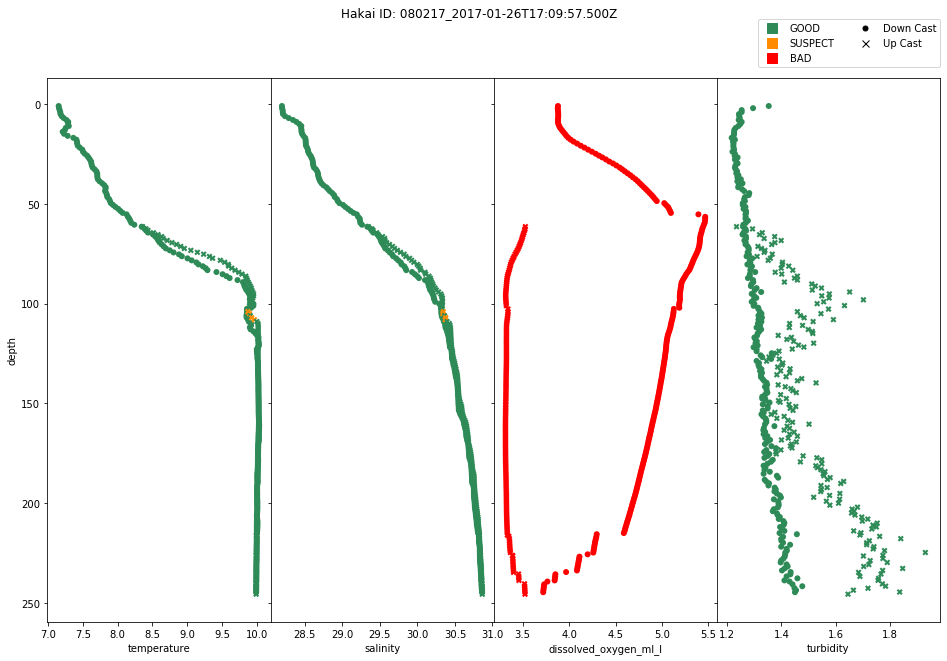

<Figure size 432x288 with 0 Axes>

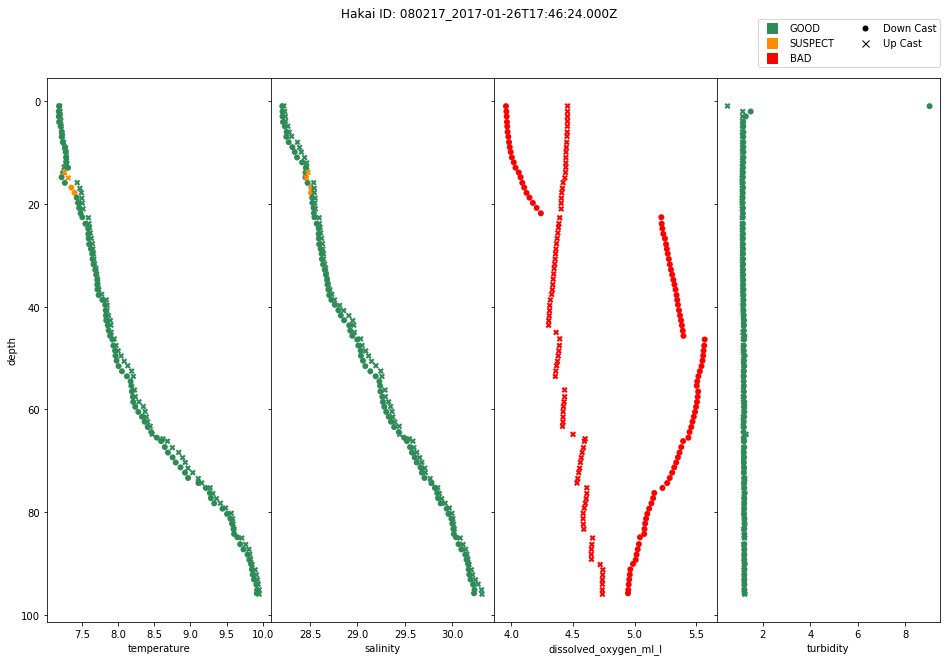

<Figure size 432x288 with 0 Axes>

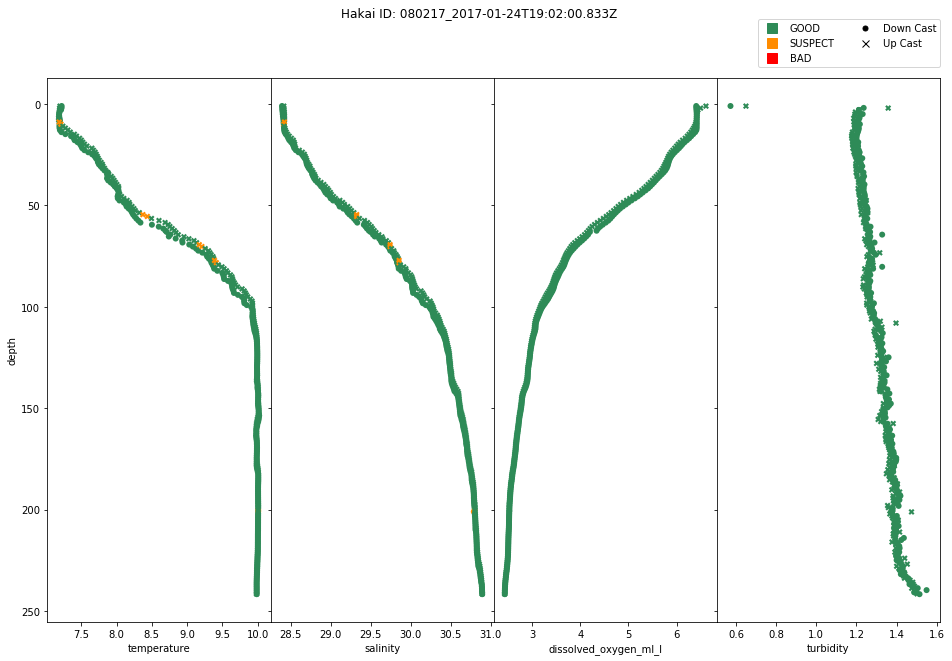

<Figure size 432x288 with 0 Axes>

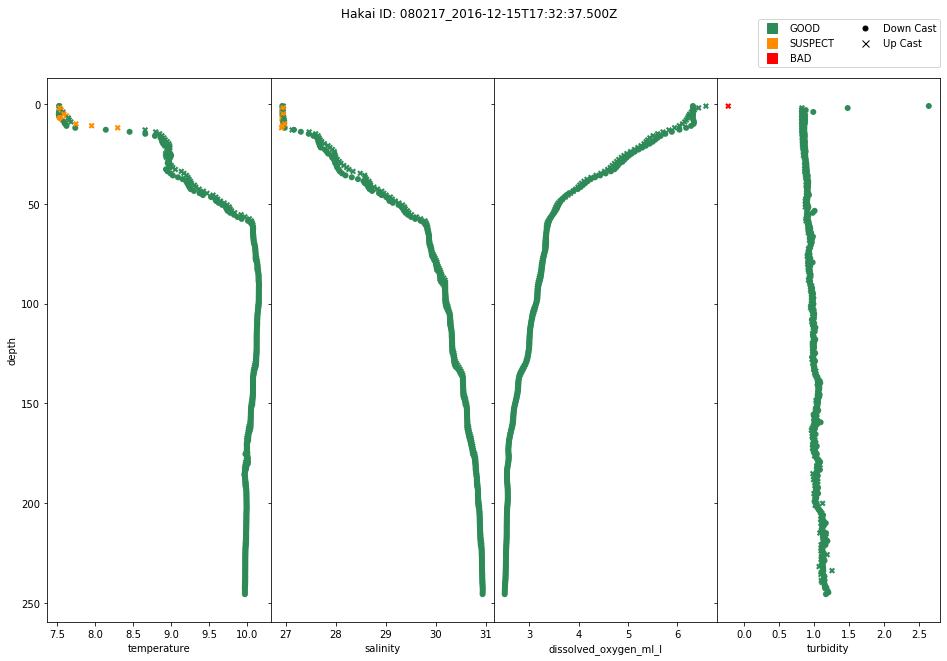

<Figure size 432x288 with 0 Axes>

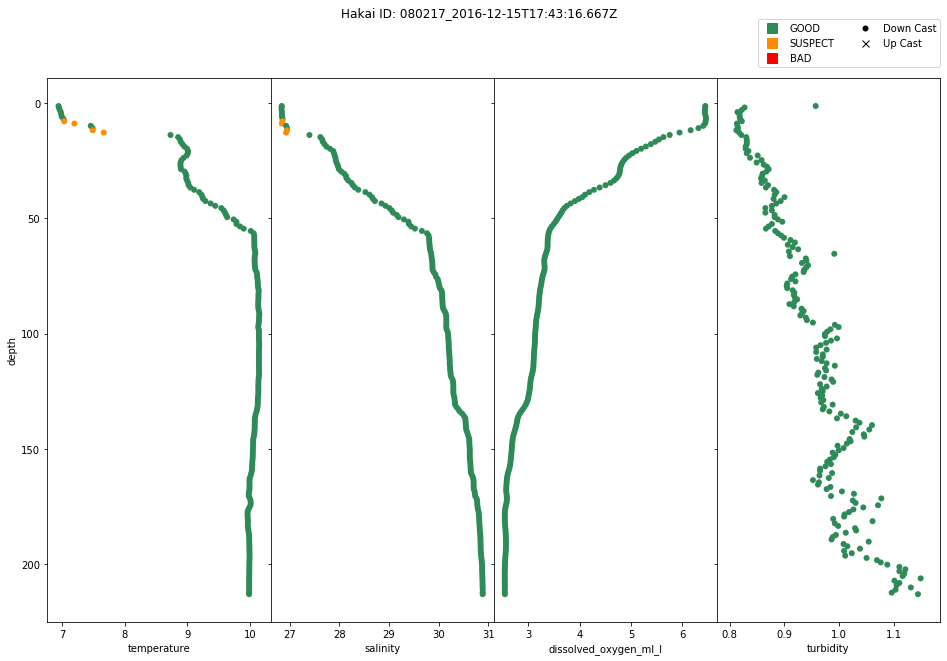

<Figure size 432x288 with 0 Axes>

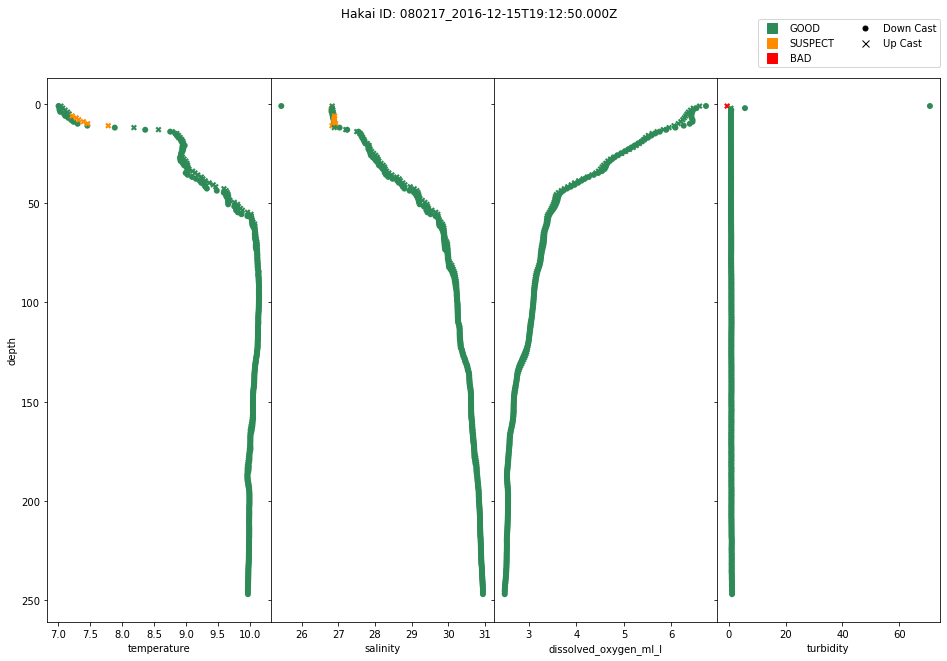

<Figure size 432x288 with 0 Axes>

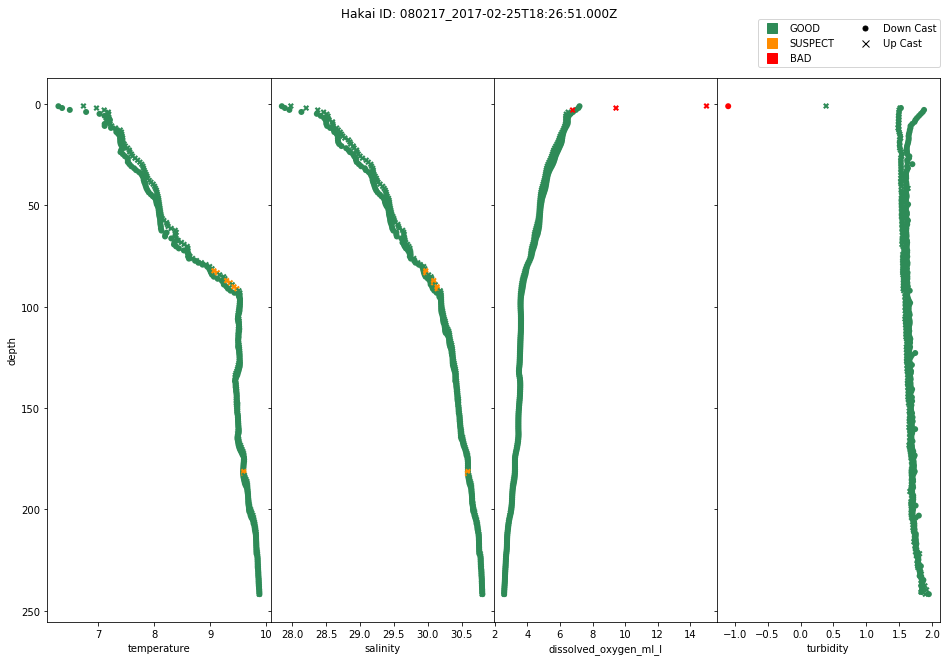

<Figure size 432x288 with 0 Axes>

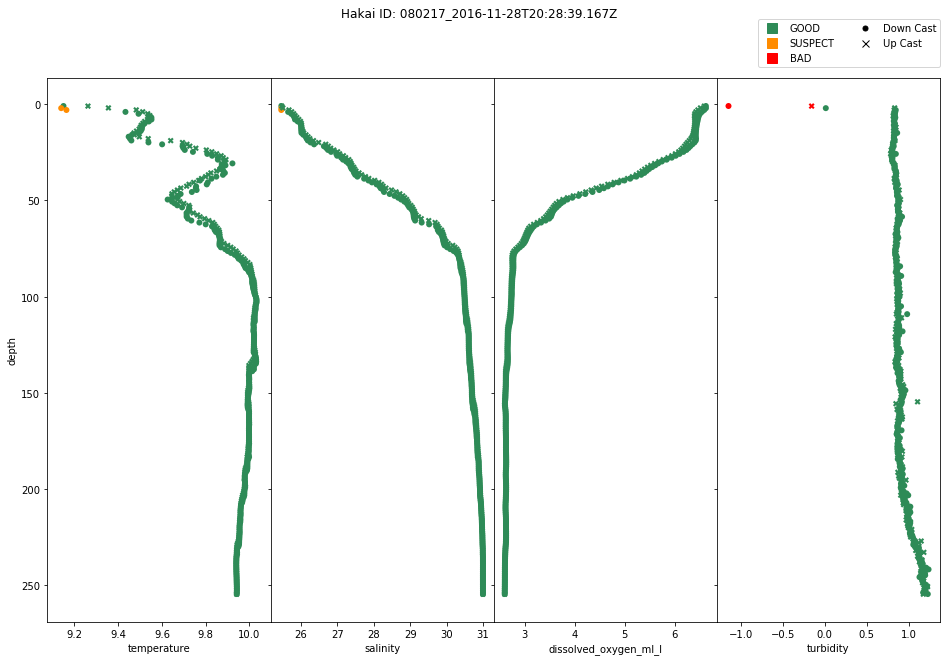

<Figure size 432x288 with 0 Axes>

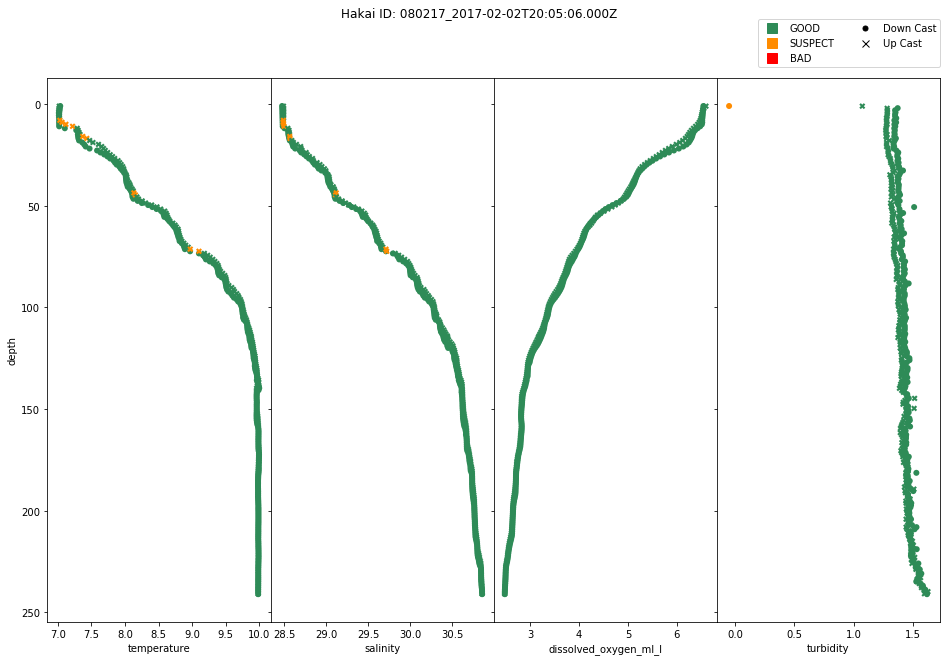

<Figure size 432x288 with 0 Axes>

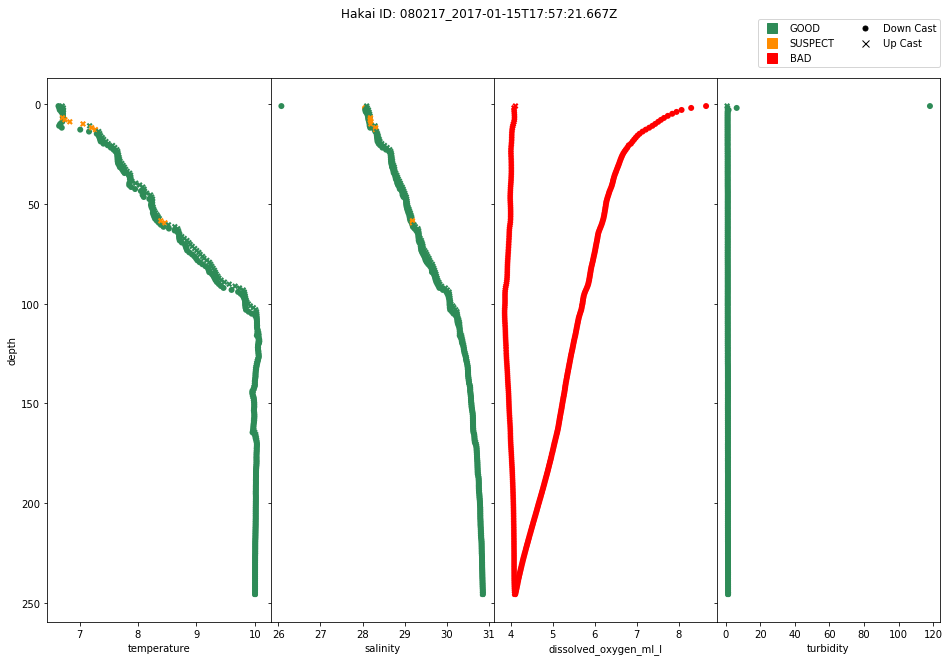

<Figure size 432x288 with 0 Axes>

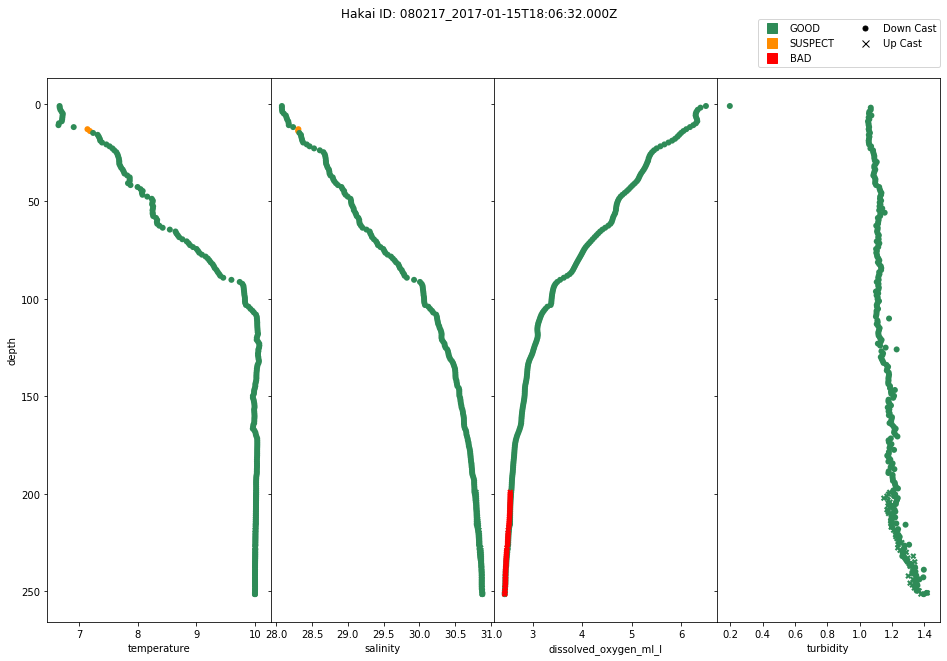

<Figure size 432x288 with 0 Axes>

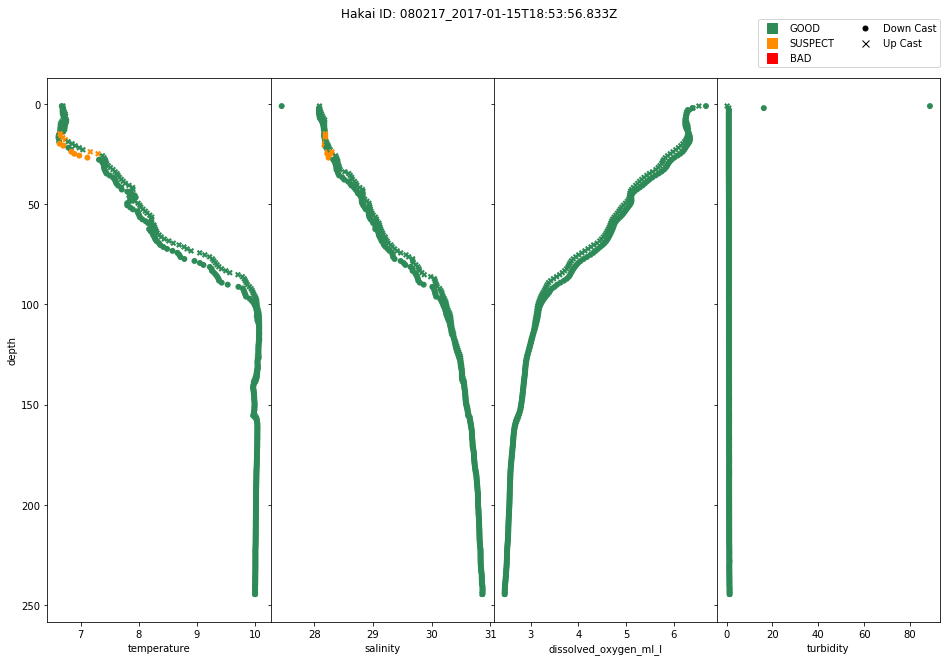

<Figure size 432x288 with 0 Axes>

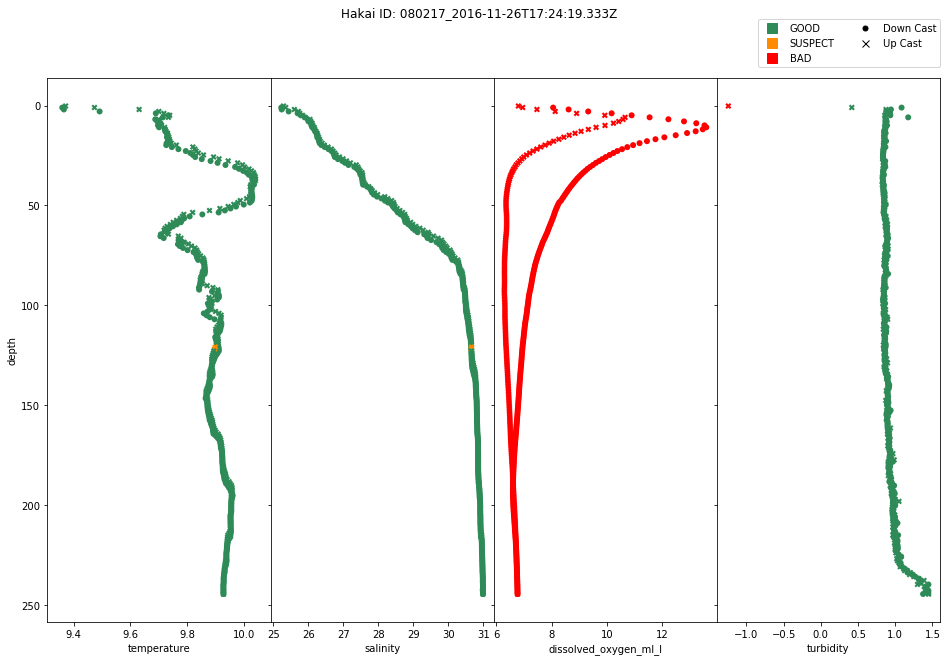

<Figure size 432x288 with 0 Axes>

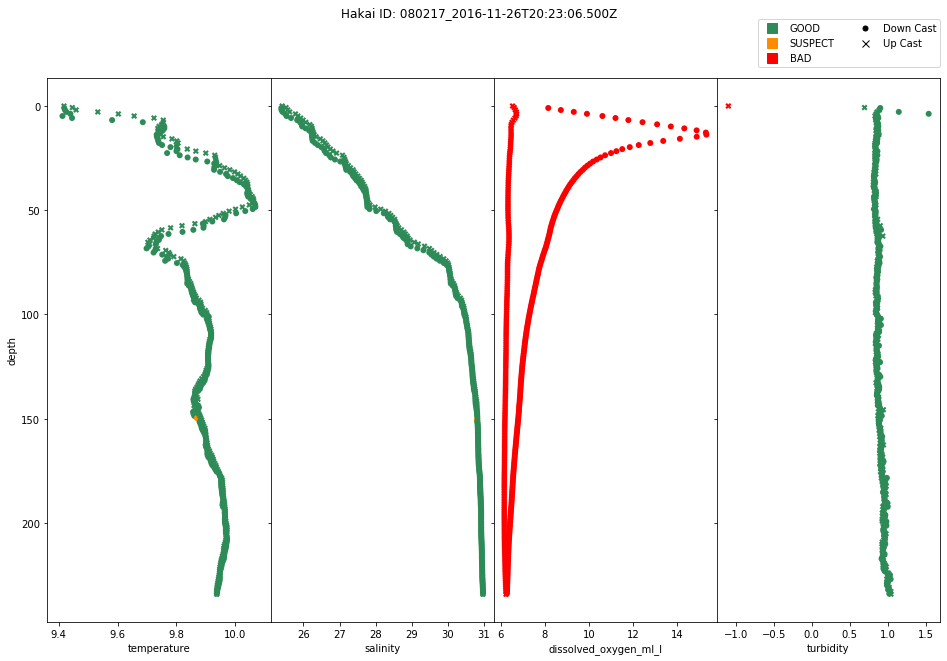

In [23]:
# Now let's plot the flagged data
hakai_qc.get.flag_result_plot(df,variables_to_plot,flagged_hakai_id[:20])